In [1]:
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np
import random

In [2]:
LFP = Structure.from_file("/data/kevinxhan/dist_chgnet/LiFePO4.cif")

In [3]:
s = LFP.make_supercell((10, 10, 10), in_place=False)
print("# of atoms in system:", len(s))
print(s.composition)
print(s.lattice)
n_Li = 4000
site_indices_to_remove = random.sample(range(0,n_Li), int(n_Li/2))
s.remove_sites(site_indices_to_remove)
print(s.composition)
print("# of atoms in system:", len(s))
supercell = s.make_supercell([2, 1, 1], in_place=False)
print("# of atoms in system:", len(supercell))
print(supercell.composition)
print(supercell.lattice)
LFP_atoms = AseAtomsAdaptor().get_atoms(supercell)
print(len(LFP_atoms))

# of atoms in system: 28000
Li+4000 Fe2+4000 P5+4000 O2-16000
46.549172 0.000000 0.000000
0.000000 59.707551 0.000000
0.000000 0.000000 102.361961
Li+2000 Fe2+4000 P5+4000 O2-16000
# of atoms in system: 26000
# of atoms in system: 52000
Li+4000 Fe2+8000 P5+8000 O2-32000
93.098344 0.000000 0.000000
0.000000 59.707551 0.000000
0.000000 0.000000 102.361961
52000


In [4]:
# create a larger system to preallocate memory with
s = LFP.make_supercell((12, 12, 12), in_place=False)
n_Li = 4000
site_indices_to_remove = random.sample(range(0,n_Li), int(n_Li/2))
s.remove_sites(site_indices_to_remove)
supercell_prealloc = s.make_supercell([2, 1, 1], in_place=False)

supercell_prealloc = supercell_prealloc.scale_lattice(supercell_prealloc.volume * 0.70)

LFP_atoms_prealloc = AseAtomsAdaptor().get_atoms(supercell_prealloc)
print(len(LFP_atoms_prealloc))

92768


In [5]:
len(supercell)/supercell.volume, len(supercell_prealloc) / supercell_prealloc.volume

(0.09138891792143265, 0.13478656545290674)

In [6]:
import matgl
from DistMLIP.implementations.matgl import Potential_Dist, PESCalculator_Dist
from DistMLIP.implementations.matgl import CHGNet_Dist, TensorNet_Dist
from DistMLIP.implementations.matgl import MolecularDynamics, Relaxer


model = matgl.load_model('/data/shared/Bowen_data/Kevin/TensorNet-MatPES-r2SCAN-2025.4.22-PES-0.3M').model
dist_model = TensorNet_Dist.from_existing(model).eval()
dist_model.enable_distributed_mode([0, 1, 2, 3, 4, 5, 6, 7])


/data/kevinxhan/miniconda3/envs/distmlip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
pes = Potential_Dist(model=dist_model, num_threads=128)

In [8]:
# Run on the prealloc
pes(LFP_atoms_prealloc)

Distributed object creation: 0.14100618500378914
Graph 0: 822144, Graph 1: 823786, Graph 2: 830826, Graph 3: 825250, Graph 4: 828768, Graph 5: 829358, Graph 6: 820692, Graph 7: 824772
Allocated (GB): ['45.44', '43.50', '43.85', '43.58', '43.76', '43.77', '43.34', '43.54']
Reserved  (GB): ['50.33', '49.65', '50.03', '49.71', '49.93', '49.98', '49.45', '49.71']


(tensor(-129769.5312, device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[ 1.1147e-02, -2.4719e-03, -1.0031e-02],
         [ 1.1141e-02, -2.4702e-03, -1.0025e-02],
         [ 3.1461e-03, -1.8666e-06, -6.6015e-03],
         ...,
         [-1.6832e+00,  2.7317e+00,  1.7199e+00],
         [-1.6945e+00,  2.7745e+00,  1.7230e+00],
         [-1.6945e+00,  2.7745e+00,  1.7230e+00]], device='cuda:0'),
 tensor([[-41.3777,   0.2897,  -0.0808],
         [  0.2897, -38.0660,   0.0833],
         [ -0.0808,   0.0833, -31.6172]], device='cuda:0'),
 None)

In [9]:
driver = MolecularDynamics(
    LFP_atoms,
    potential=pes,
    timestep=2,
    temperature=1000,
    # logfile="H2O_0.1M_1000k.log",
    # trajectory="H2O_0.1M_1000k.traj",
    loginterval=100000
)

driver.run(2000)

/data/kevinxhan/DistMLIP/DistMLIP/implementations/matgl/ase.py:291: FutureWarning: Please use atoms.calc = calc
  self.atoms.set_calculator(


Distributed object creation: 0.12156325600517448
Graph 0: 297108, Graph 1: 292000, Graph 2: 298992, Graph 3: 290800, Graph 4: 300240, Graph 5: 290860, Graph 6: 290880, Graph 7: 298976
Allocated (GB): ['17.36', '16.06', '16.47', '16.00', '16.53', '16.01', '16.08', '16.50']
Reserved  (GB): ['53.86', '53.19', '53.60', '53.25', '53.49', '53.54', '52.97', '53.25']


/data/kevinxhan/miniconda3/envs/distmlip/lib/python3.10/site-packages/ase/md/nvtberendsen.py:98: RuntimeWarning: divide by zero encountered in scalar divide
  1.0 + (self.temperature / old_temperature - 1.0) * tautscl


Step time: 0.9148969569941983
Distributed object creation: 0.12449257900880184
Graph 0: 293070, Graph 1: 296586, Graph 2: 294406, Graph 3: 294308, Graph 4: 296732, Graph 5: 296162, Graph 6: 293936, Graph 7: 294656
Allocated (GB): ['17.14', '16.33', '16.22', '16.20', '16.34', '16.31', '16.19', '16.22']
Reserved  (GB): ['53.86', '53.19', '53.60', '53.25', '53.49', '53.54', '52.97', '53.25']
Step time: 0.9193659349984955
Distributed object creation: 0.11889026100107003
Graph 0: 293120, Graph 1: 296586, Graph 2: 294406, Graph 3: 294308, Graph 4: 296732, Graph 5: 295958, Graph 6: 294140, Graph 7: 294606
Allocated (GB): ['17.14', '16.33', '16.22', '16.20', '16.34', '16.30', '16.20', '16.22']
Reserved  (GB): ['53.86', '53.19', '53.60', '53.25', '53.49', '53.54', '52.97', '53.25']
Step time: 0.9005982700036839
Distributed object creation: 0.12120409798808396
Graph 0: 293120, Graph 1: 296586, Graph 2: 294406, Graph 3: 294308, Graph 4: 296732, Graph 5: 295958, Graph 6: 294140, Graph 7: 294606
Al

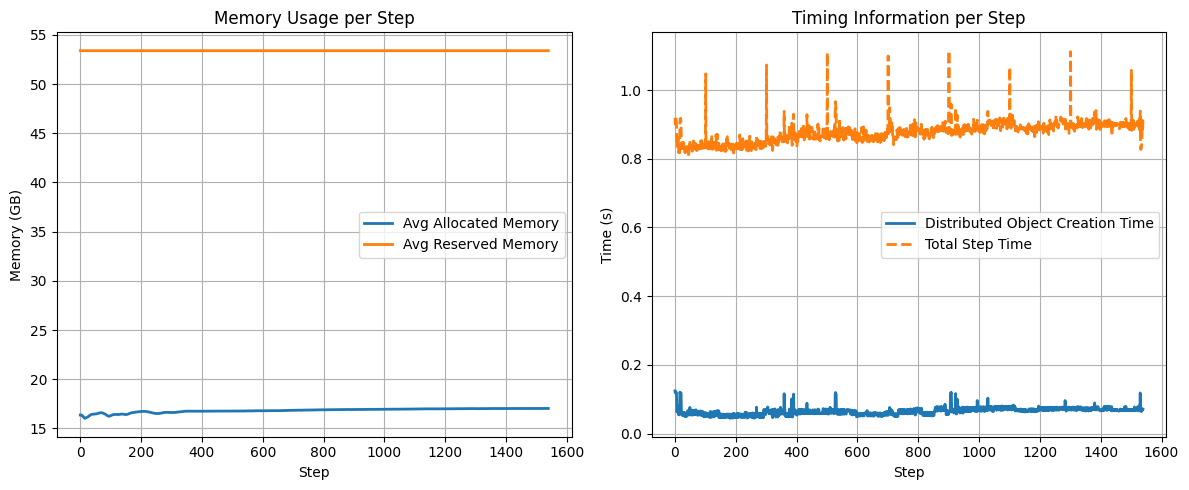

In [4]:
import re
import matplotlib.pyplot as plt

# Read file content into a string
with open('nohup.out', 'r') as file:
    data = file.read()

# Regex patterns
allocated_pattern = re.compile(r"Allocated \(GB\): \[([^\]]+)\]")
reserved_pattern = re.compile(r"Reserved\s+\(GB\): \[([^\]]+)\]")
distributed_pattern = re.compile(r"Distributed object creation: ([\d.]+)")
step_time_pattern = re.compile(r"Step time: ([\d.]+)")

# Extract values
allocated_matches = allocated_pattern.findall(data)
reserved_matches = reserved_pattern.findall(data)
distributed_times = [float(x) for x in distributed_pattern.findall(data)]
step_times = [float(x) for x in step_time_pattern.findall(data)][1:]

# Compute averages
average_allocated = []
average_reserved = []

for alloc, resv in zip(allocated_matches, reserved_matches):
    alloc_vals = [float(val.strip().strip("'")) for val in alloc.split(',')]
    resv_vals = [float(val.strip().strip("'")) for val in resv.split(',')]
    average_allocated.append(sum(alloc_vals) / len(alloc_vals))
    average_reserved.append(sum(resv_vals) / len(resv_vals))

# Time steps
steps = list(range(len(average_allocated)))

# Plot 1: Memory usage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, average_allocated, label='Avg Allocated Memory', linewidth=2)
plt.plot(steps, average_reserved, label='Avg Reserved Memory', linewidth=2)
plt.title('Memory Usage per Step')
plt.xlabel('Step')
plt.ylabel('Memory (GB)')
plt.legend()
plt.grid(True)

# Plot 2: Timing info
plt.subplot(1, 2, 2)
plt.plot(steps, distributed_times, label='Distributed Object Creation Time', linewidth=2)
plt.plot(steps, step_times, label='Total Step Time', linestyle='--', linewidth=2)
plt.title('Timing Information per Step')
plt.xlabel('Step')
plt.ylabel('Time (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
